In [1]:
import pickle

In [2]:
odcf = False
#pc006 = True
if odcf:
    data_dir = "/omics/groups/OE0540/internal/users/mikulik/master_thesis/data/gcs_basenj/"
    from data_utils import * 
    
else:
    data_dir = "/data/mikulik/mnt/gcs_basenj/"
    from deepmind_utils import * 

print(data_dir)

# the trained enformer model is available under:
model_path = 'https://tfhub.dev/deepmind/enformer/1'


2023-08-16 11:46:01.986295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/mikulik/mnt/gcs_basenj/


In [3]:
#specify device cpu, because the model does not fit on the GPU
tf.device('/cpu:0')
SEQUENCE_LENGTH = 393216
TARGET_LENGTH = 896
BIN_SIZE = 128
experiments_human = 5313
experiments_mouse = 1643

2023-08-16 11:46:06.960708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-16 11:46:06.960738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: b260-pc006
2023-08-16 11:46:06.960743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: b260-pc006
2023-08-16 11:46:06.960808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.89.2
2023-08-16 11:46:06.960841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.89.2
2023-08-16 11:46:06.960846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.89.2
2023-08-16 11:46:06.961496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with one

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
tf.config.experimental.list_physical_devices('CPU')
tf.device('/CPU:0')


Num GPUs Available:  0
Num CPUs Available:  1


In [5]:
with tf.device("CPU"):
    enformer_model = hub.load("https://tfhub.dev/deepmind/enformer/1").model#, options=tf_obj).model
#tf.config.list_physical_devices("CPU")
#enformer = Enformer(model_path, "CPU")


In [6]:
target_df = pd.read_csv(os.path.join(data_dir, "human", "targets.txt"), sep = "\t")
target_df[["experiment", "descr"]] = target_df.description.str.split(":", n=1, expand=True)
cage_index = target_df["experiment"].str.contains("CAGE")#.index


In [7]:
def plot_corr_across_positions(corr_vec, target_df, title=None, color=None):
    for i in target_df.experiment.unique():
        if i == "CHIP":
            sub_histone = target_df[target_df.description.str.contains("H3K")].index
            sub_tf = target_df[(~target_df.description.str.contains("H3K")) & (target_df.experiment == "CHIP")].index
            for ind, name in zip([sub_histone, sub_tf], ["Histone-CHIP", "TF-CHIP"]):
                sub = corr_vec[ind]
                sns.histplot(sub, color=color)
                plt.xlabel("Correlation across all 128 bp positions in the test set")
                plt.title(f"{title}, exp: {i}, mean: {sub.mean():.3f}")
                plt.show()
        else: 
            index = target_df[target_df["experiment"] == i].index
            sub = corr_vec[index]
            sns.histplot(sub, color=color)
            plt.xlabel("Correlation across all 128 bp positions in the test set")
            plt.title(f"{title}, exp: {i}, mean: {sub.mean():.3f}")
            plt.show()

In [8]:
def plot_comparison_corr_across_positions(corr1, corr2, target_df, xlab=None, ylab=None, title=None, color="black", save_pdf=None):
    for i in target_df.experiment.unique():
        if i == "CHIP":
            sub_histone = target_df[target_df.description.str.contains("H3K")].index
            sub_tf = target_df[(~target_df.description.str.contains("H3K")) & (target_df.experiment == "CHIP")].index
            for ind, name in zip([sub_histone, sub_tf], ["Histone-CHIP", "TF-CHIP"]):
                sub1, sub2 = corr1[ind], corr2[ind]
                sns.scatterplot(x=sub1, y=sub2, color=color)
                sns.kdeplot(x=sub1, y=sub2, fill=True, alpha=0.6, cmap="Blues")
                sns.lineplot(x=[0,1], y=[0,1], color="black")
                plt.title(f"{title}, {name}, Correlation across all 128 bp positions in the test set")
                plt.xlabel(f"{xlab}, exp: {name}, mean: {sub1.mean():.3f}")
                plt.ylabel(f"{ylab}, exp: {name}, mean: {sub2.mean():.3f}")
                plt.xlim(0,1)
                plt.ylim(0,1)
                if save_pdf != None:
                    plt.savefig(os.path.join(save_pdf,  f'{xlab}_{ylab}_cross_pos_{name}.pdf'), format='pdf')
                plt.show()
        else: 
            index = target_df[target_df["experiment"] == i].index
            sub1, sub2 = corr1[index], corr2[index]
            sns.scatterplot(x=sub1, y=sub2, color=color)
            sns.kdeplot(x=sub1, y=sub2, fill=True, alpha=0.6, cmap="Blues")
            sns.lineplot(x=[0,1], y=[0,1], color="black")
            plt.title(f"{title}, {i}, Correlation across all 128 bp positions in the test set")
            plt.xlabel(f"{xlab}, exp: {i}, mean: {sub1.mean():.3f}")
            plt.ylabel(f"{ylab}, exp: {i}, mean: {sub2.mean():.3f}")
            plt.xlim(0,1)
            plt.ylim(0,1)
            if save_pdf:
                plt.savefig(os.path.join(save_pdf,  f'{xlab}_{ylab}_cross_pos_{i}.pdf'), format='pdf')
            plt.show()

### Forward pass with trained model
Create a validation dataset. Write a forward loop. 

# Correlations across all positions per experimental track

For each experimental track I compute the correlation across all 128 bp bins of the sequences in the test, train or validaition set.

$y^{pred} \in \mathbb{R}^p$ is the predicted vector of signal at all positions p in all sequences. $y^{obs} \in \mathbb{R}^p$ is the observed signal at all positions p in all sequences. The correlation is computed as:

**Pearson correlation**


$$\frac{1}{P}\frac{\sum_{i=1}^P(y^{pred}_i - \bar{y}^{pred})(y^{obs}_i - \bar{y}^{obs})}{\sqrt{var(y^{pred})} \sqrt{var(y^{obs})}}$$



For some reason the fucntion from online did not work so I wrote my own function

In [9]:
run = False
if run: 
  human_fasta_path = f"{data_dir}hg38.ml.fa"
  ds = DeepMindData("human", "test", seq_len=393216, fasta_path=human_fasta_path)
  max_steps=None
  metric = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
  count=0
  def predict(x):
      return enformer_model.predict_on_batch(x)["human"]
  for i, batch in enumerate(iter(ds)):
      count+=1
      if count % 100 == 0:
        print(count)
      if max_steps is not None and i > max_steps:
        break
      tar = tf.expand_dims(batch["target"], axis=0)
      preds = predict(tf.expand_dims(batch["sequence"], axis=0))
      metric.update_state(tar, preds)

  metric_human = metric.result()
  print('')
  print({k: v.numpy().mean() for k, v in metric_human.items()})
else:
   with open("/data/mikulik/mnt/gcs_basenj/corr_across_positions/enformer_corr_across_positions_enformer_original.pkl", "rb") as f:
         corr_tensor = pickle.load(f)
   

In [10]:
#plot_corr_across_positions(corr_tensor.numpy(), target_df, title="Original Enformer")

# Small Enformer & Basenji

In [11]:
corr_dict = {}
for file in os.listdir(os.path.join(data_dir, "corr_across_positions")):
    with open(os.path.join(data_dir, "corr_across_positions", file), "rb") as f:
        corr = pickle.load(f)
    corr_dict[file] = corr.numpy()
corr_dict

{'enformer_corr_across_positions_enformer_original.pkl': array([0.86485904, 0.8890622 , 0.8383608 , ..., 0.68737864, 0.7221663 ,
        0.70538586], dtype=float32),
 'basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_model_validation_checkpoint_human_test_set_corr_across_pos.pkl': array([0.824781  , 0.8442816 , 0.78975177, ..., 0.5814141 , 0.64042157,
        0.6055262 ], dtype=float32),
 'basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl': array([0.820236  , 0.8385317 , 0.78119594, ..., 0.5536206 , 0.6479039 ,
        0.61089975], dtype=float32),
 'basenji_res_con_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl': array([0.8357465 , 0.85356337, 0.79282904, ..., 0.58859736, 0.6386402 ,
        0.60823286], dtype=float32),
 'old_basenji_0.15_sgd_4_augmentTr

In [14]:
for key, value in corr_dict.items():
    print(f"{key}: {value.mean()}")

enformer_corr_across_positions_enformer_original.pkl: 0.6681367754936218
basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_model_validation_checkpoint_human_test_set_corr_across_pos.pkl: 0.592301607131958
basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl: 0.5881603956222534
basenji_res_con_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl: 0.6042642593383789
old_basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_mouse_test_set_corr_across_pos.pkl: 0.672033429145813
basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_mouse_test_set_corr_across_pos.pkl: 0.6773989200592041
enf_train_v2_batch_2_lr_1e3_linear_noi

In [12]:
from architecture_nolinear import Enformer
m = Enformer.from_hparams(
        dim = 1536,
        depth = 5,
        heads = 8,
        use_checkpointing=True,
        output_heads = dict(human = 5313, mouse= 1643),
        target_length = 896,
    )

import torch.nn as nn
m = nn.DataParallel(m)
m.load_state_dict(torch.load(os.path.join(data_dir, "models", "enf_train_v2_batch_12_lr_1e4_training_state_dict.pt"), map_location=torch.device('cpu')))

total_params = sum(p.numel() for p in m.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 93546284


In [18]:
#np.arange(SEQUENCE_LENGTH)
#extactro = FastaStringExtractor(os.path.join(data_dir, "hg38.ml.fa"))
#seq = extactro.extract(kipoiseq.Interval("chr1", 435324, 435324 + SEQUENCE_LENGTH))
#seq = one_hot_encode(seq)
#seq.shape

(393216, 4)

In [18]:
from architecture_linear import Enformer
m = Enformer.from_hparams(
        dim = 1536,
        depth = 5,
        heads = 8,
        use_checkpointing=True,
        output_heads = dict(human = 5313, mouse= 1643),
        target_length = 896,
    )

import torch.nn as nn
m.load_state_dict(torch.load(os.path.join(data_dir, "models", "enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict.pt"), map_location=torch.device('cpu')))

total_params = sum(p.numel() for p in m.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 140770604


### Orignal vs Small Enformer

In [53]:
data_dir

'/data/mikulik/mnt/gcs_basenj/'

In [59]:
print(f"enf_linear: {corr_dict['enf_train_v2_batch_12_lr_1e4_training_state_dict_human_test_set_corr_across_pos.pkl'].mean()}, enf_nolinear:{corr_dict['enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_human_test_set_corr_across_pos.pkl'].mean()}")

enf_linear: 0.6109436750411987, enf_nolinear:0.6209078431129456


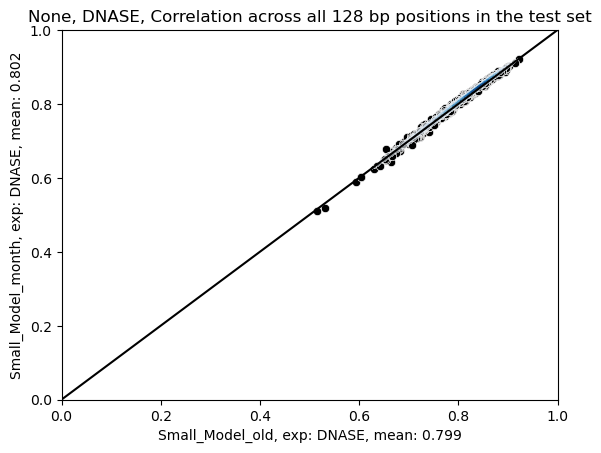

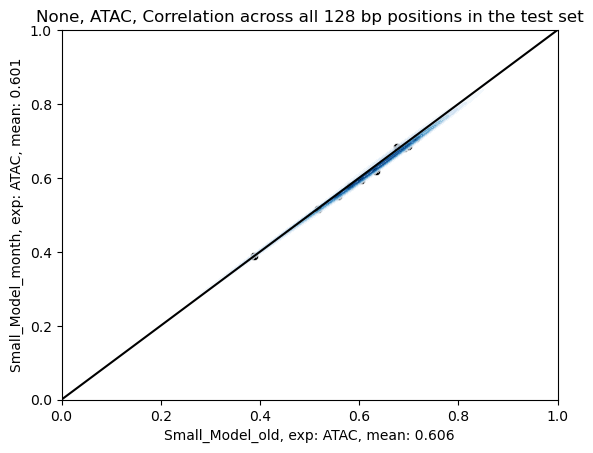

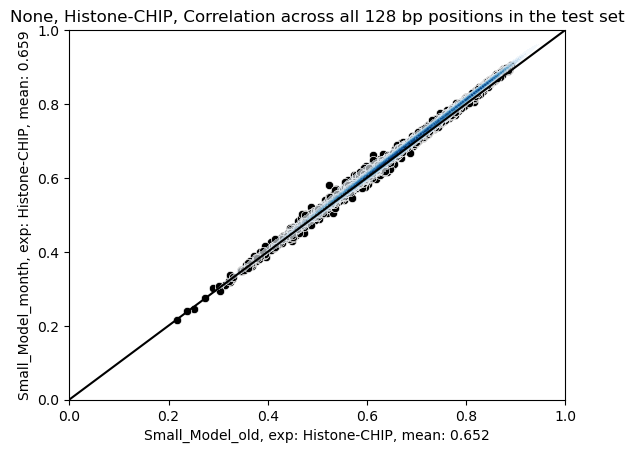

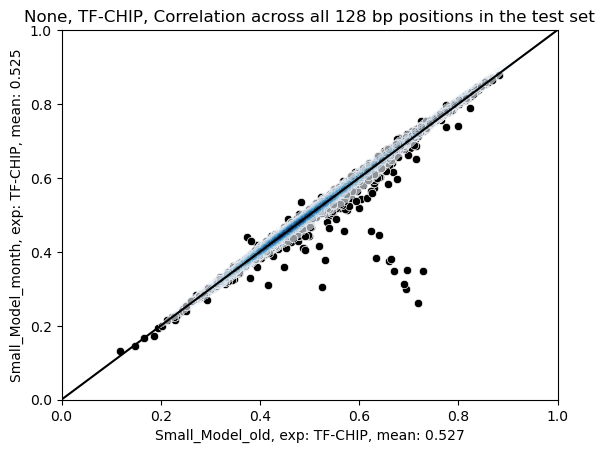

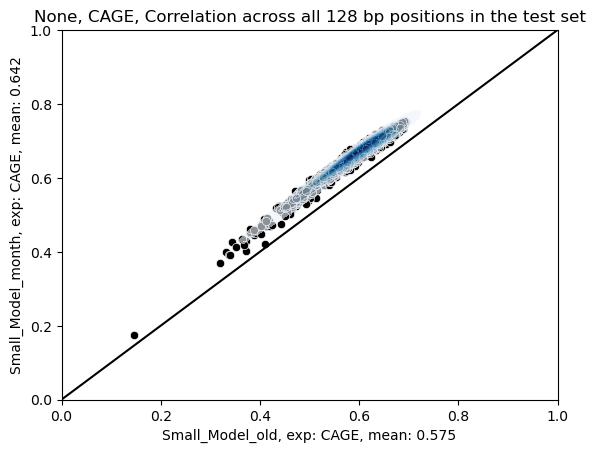

In [60]:

plot_comparison_corr_across_positions(corr_dict["enf_train_v2_batch_12_lr_1e4_training_state_dict_human_test_set_corr_across_pos.pkl"],
                                    corr_dict["enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_human_test_set_corr_across_pos.pkl"], 
                                    target_df=target_df,
                                    xlab="Small_Model_old",
                                    ylab="Small_Model_month",
                                    save_pdf=os.path.join(data_dir, "plots"))

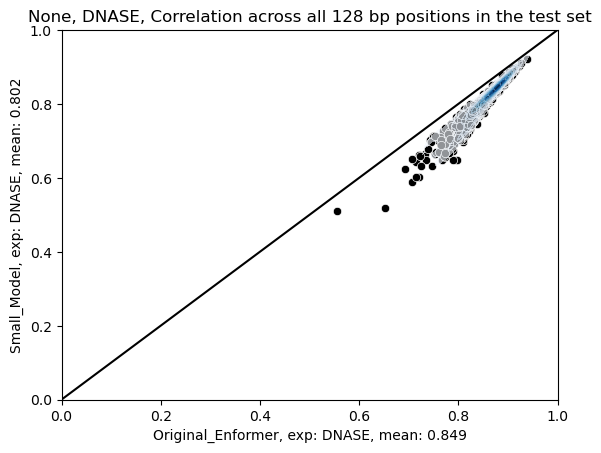

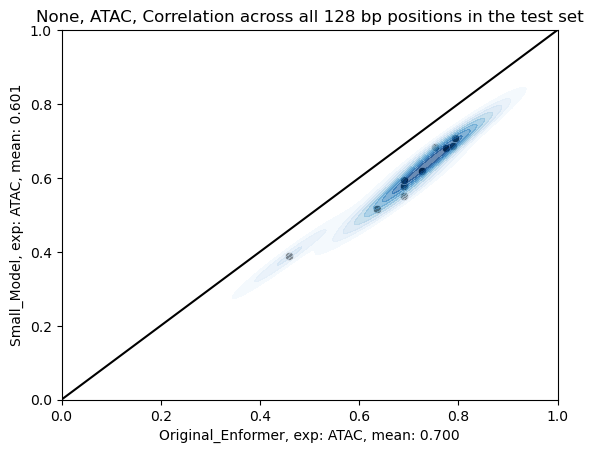

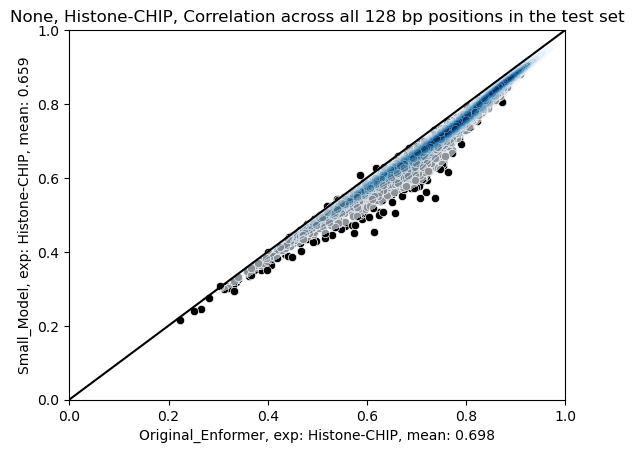

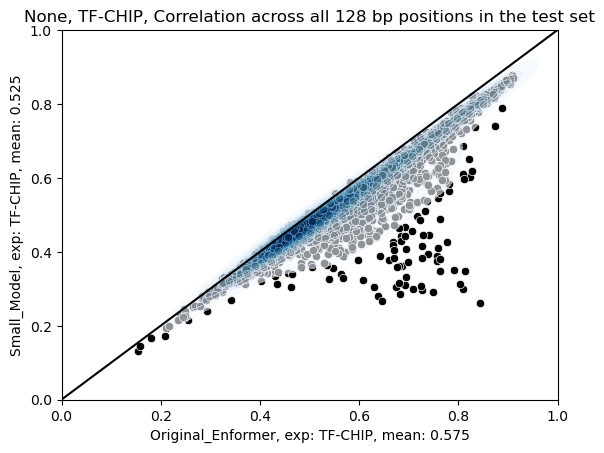

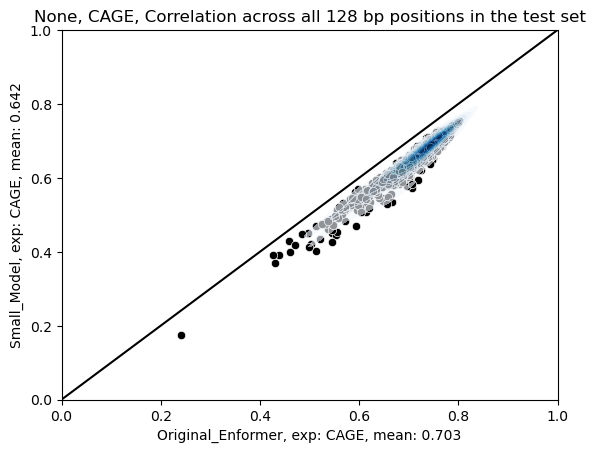

In [18]:
plot_comparison_corr_across_positions(corr_dict["enformer_corr_across_positions_enformer_original.pkl"],
                                    corr_dict["enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_human_test_set_corr_across_pos.pkl"], 
                                    target_df=target_df,
                                    xlab="Original_Enformer",
                                    ylab="Small_Model",
                                    save_pdf=os.path.join(data_dir, "plots"))

### Small Enformer vs Basenji

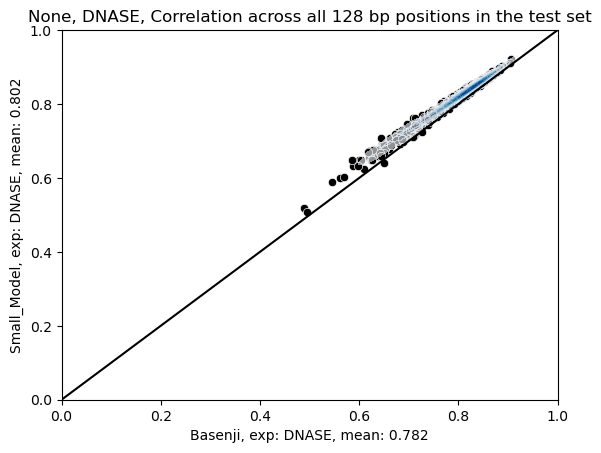

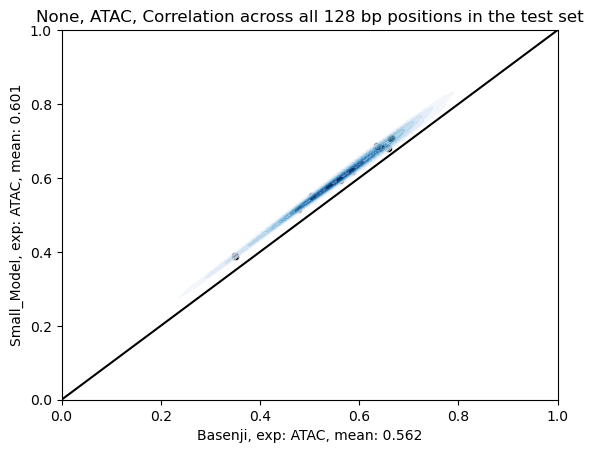

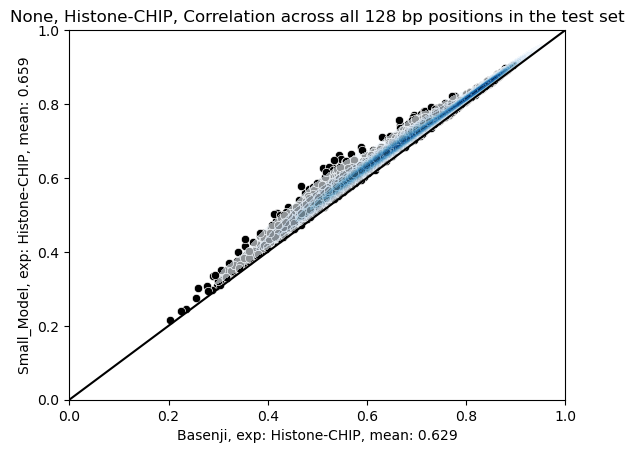

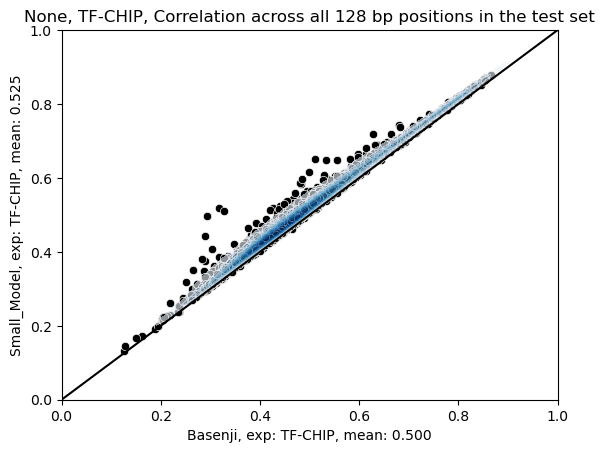

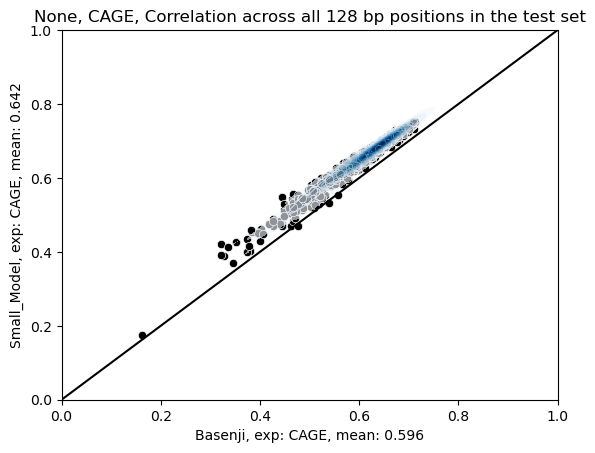

In [19]:
plot_comparison_corr_across_positions(corr_dict["basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_model_validation_checkpoint_human_test_set_corr_across_pos.pkl"],
                                    corr_dict["enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_human_test_set_corr_across_pos.pkl"], 
                                    target_df=target_df,
                                    xlab="Basenji",
                                    ylab="Small_Model",
                                    save_pdf=os.path.join(data_dir, "plots"))

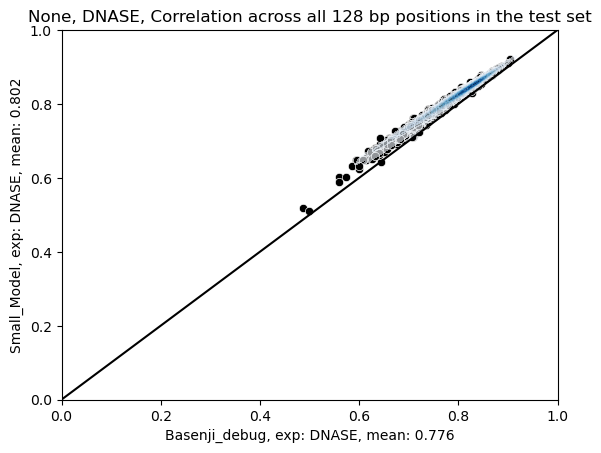

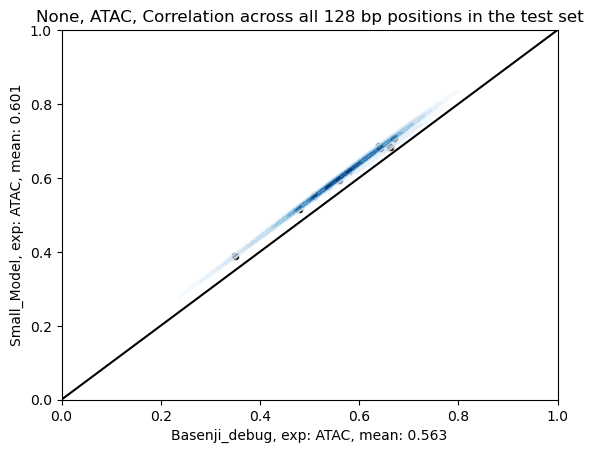

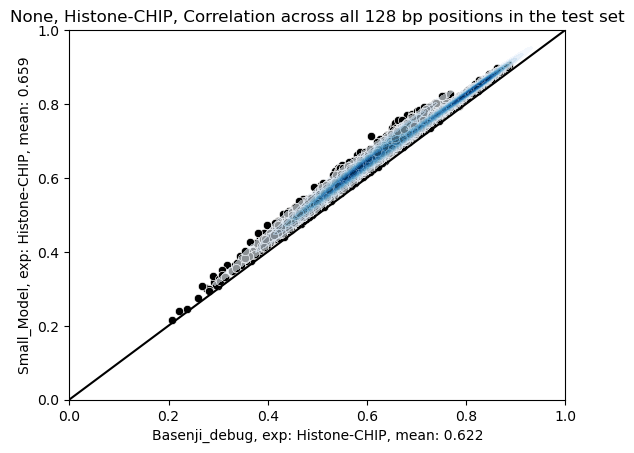

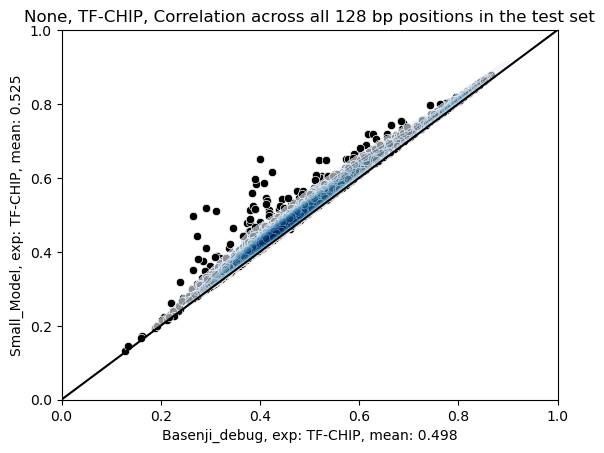

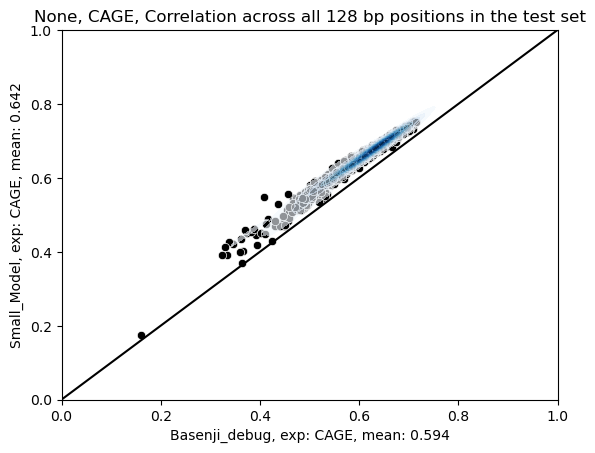

In [20]:
plot_comparison_corr_across_positions(corr_dict["basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl"],
                                    corr_dict["enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_human_test_set_corr_across_pos.pkl"], 
                                    target_df=target_df,
                                    xlab="Basenji_debug",
                                    ylab="Small_Model")

# Basenji_wrong_dil vs Basenji_dil


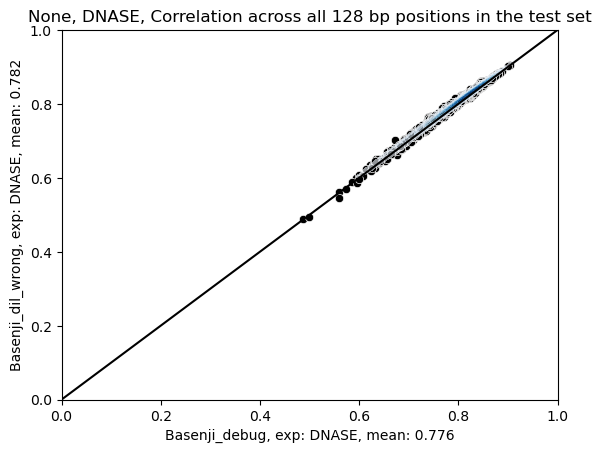

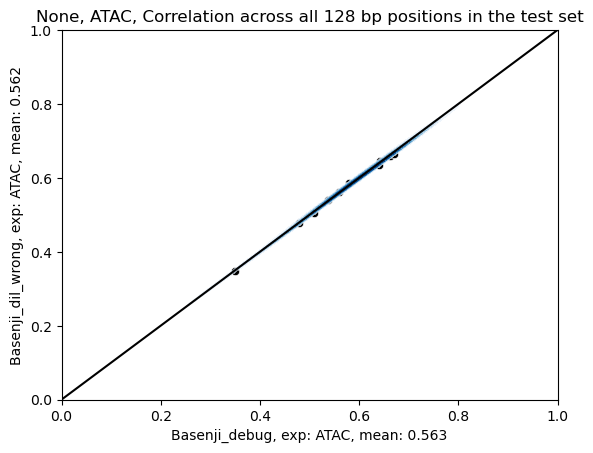

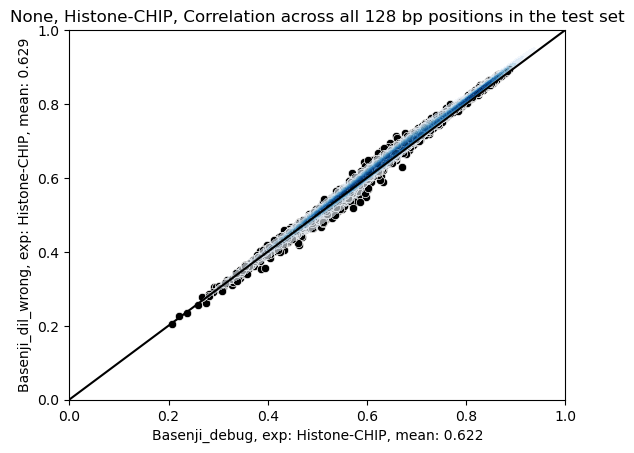

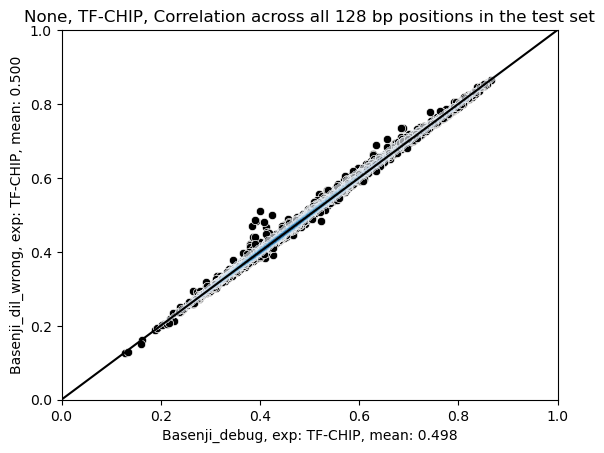

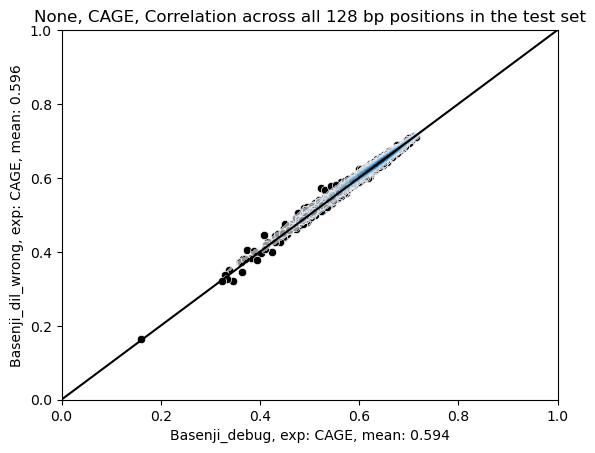

In [21]:
plot_comparison_corr_across_positions(corr_dict["basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl"],
                                    corr_dict["basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_model_validation_checkpoint_human_test_set_corr_across_pos.pkl"], 
                                    target_df=target_df,
                                    xlab="Basenji_debug",
                                    ylab="Basenji_dil_wrong")

### Basenji vs Original Enformer

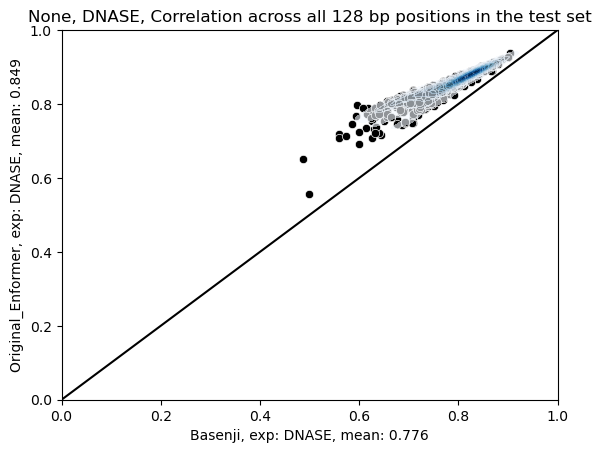

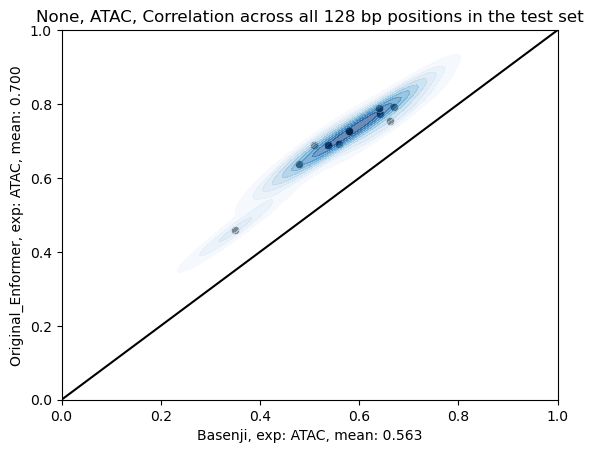

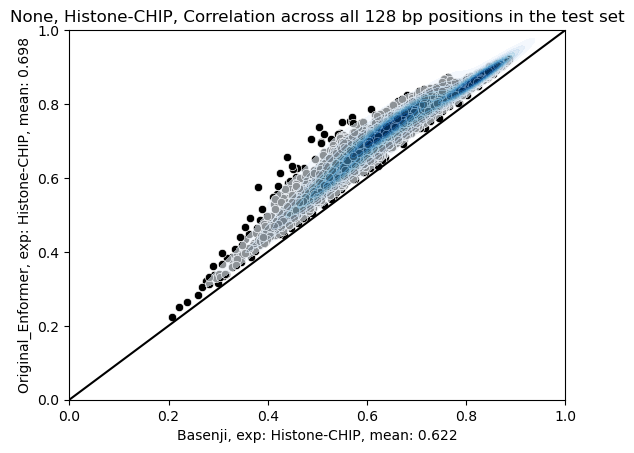

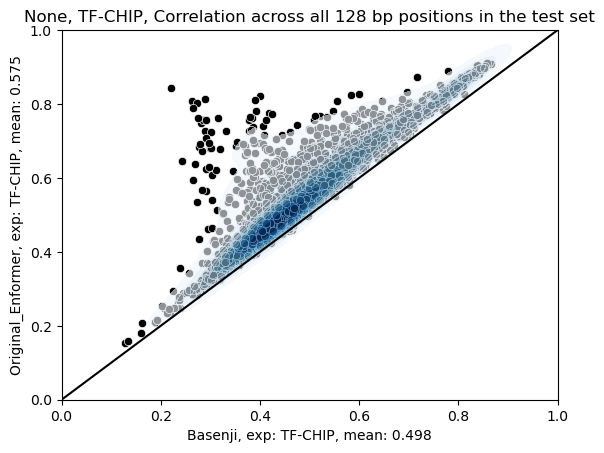

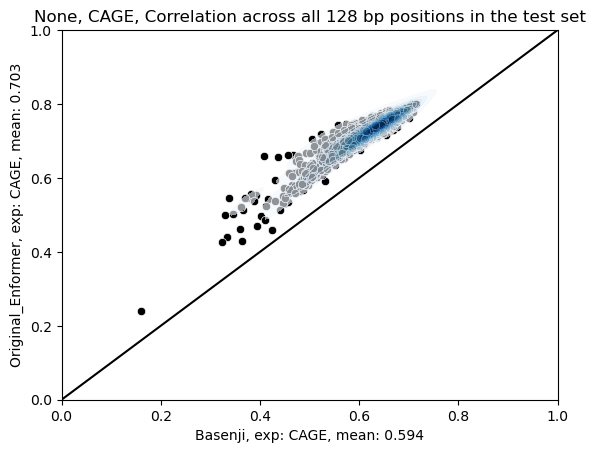

In [17]:
plot_comparison_corr_across_positions(corr_dict["basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl"],
                                    corr_dict["enformer_corr_across_positions_enformer_original.pkl"], 
                                    target_df=target_df,
                                    ylab="Original_Enformer",
                                    xlab="Basenji",
                                    save_pdf=os.path.join(data_dir, "plots"))

# Debugged Basenji2 with activation after res con

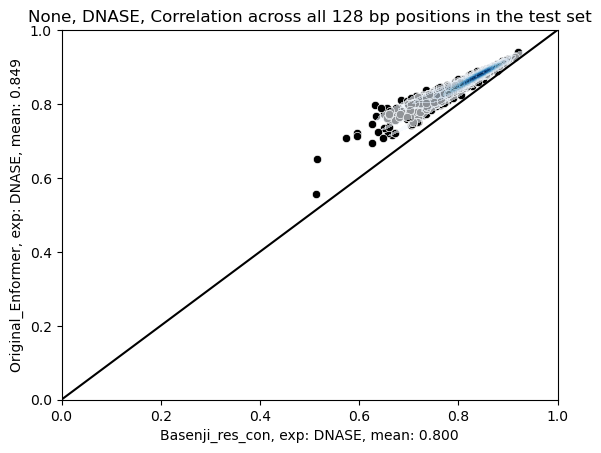

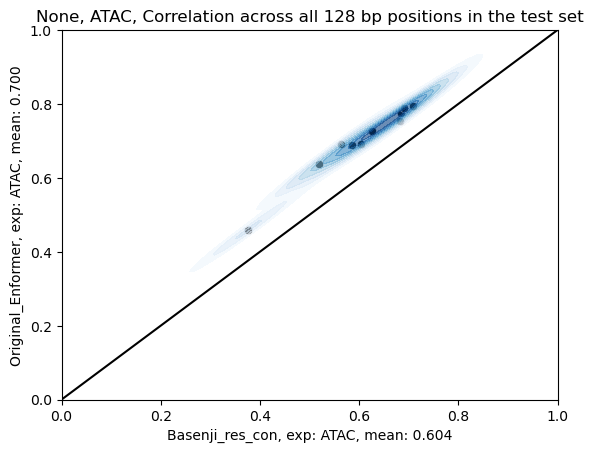

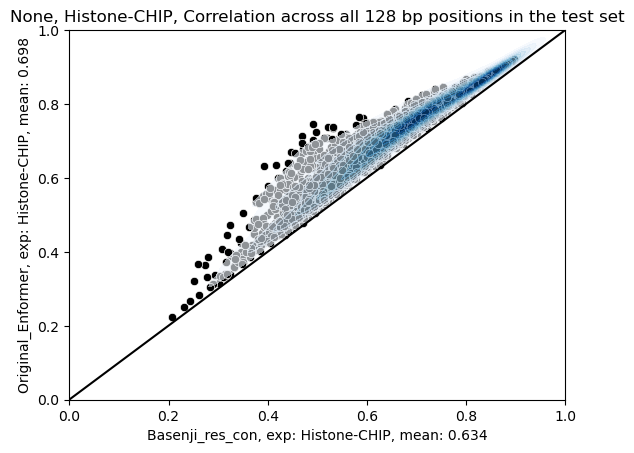

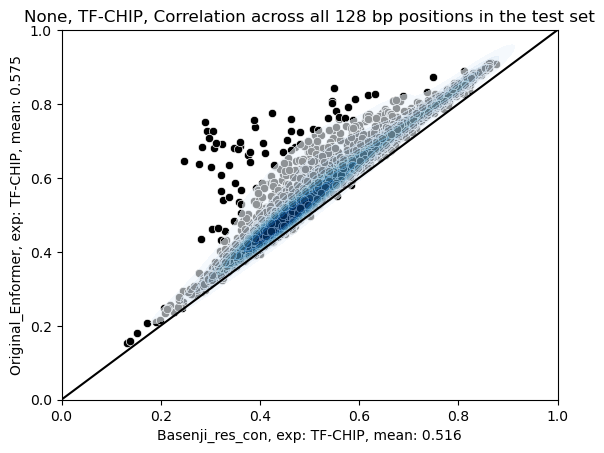

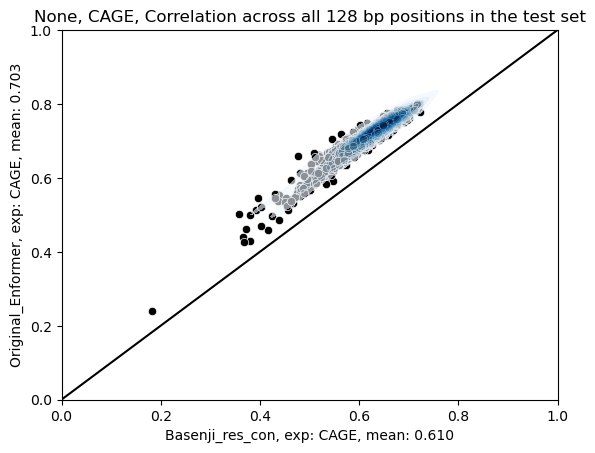

In [16]:
plot_comparison_corr_across_positions(corr_dict["basenji_res_con_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_human_test_set_corr_across_pos.pkl"],
                                    corr_dict["enformer_corr_across_positions_enformer_original.pkl"], 
                                    target_df=target_df,
                                    ylab="Original_Enformer",
                                    xlab="Basenji_res_con",
                                    save_pdf=os.path.join(data_dir, "plots"))

### Basenji vs Small Enformer - MOUSE

In [ ]:
target_df = pd.read_csv(os.path.join(data_dir, "human", "targets.txt"), sep = "\t")
target_df[["experiment", "descr"]] = target_df.description.str.split(":", n=1, expand=True)
cage_index = target_df["experiment"].str.contains("CAGE")#.index

In [44]:
mouse_targets = pd.read_csv(os.path.join(data_dir, "mouse", "targets.txt"), sep="\t", header=0)
mouse_targets[["experiment", "descr"]] = mouse_targets.description.str.split(":", n=1, expand=True)
mouse_targets



,index,genome,identifier,file,clip,scale,sum_stat,description,experiment,descr
0,0,1,ENCFF866ZTV,/home/drk/tillage/datasets/mouse/dnase/encode/...,32,2,mean,DNASE:B6D2F1/J 416B,DNASE,B6D2F1/J 416B
1,1,1,ENCFF695LHM,/home/drk/tillage/datasets/mouse/dnase/encode/...,32,2,mean,DNASE:BALB/cAnN A20,DNASE,BALB/cAnN A20
2,2,1,ENCFF079SPZ,/home/drk/tillage/datasets/mouse/dnase/encode/...,32,2,mean,DNASE:C57BL/6 B cell male adult (8 weeks),DNASE,C57BL/6 B cell male adult (8 weeks)
3,3,1,ENCFF798VSP,/home/drk/tillage/datasets/mouse/dnase/encode/...,32,2,mean,DNASE:C57BL/6 splenic B cell male adult (8 weeks),DNASE,C57BL/6 splenic B cell male adult (8 weeks)
4,4,1,ENCFF474GND,/home/drk/tillage/datasets/mouse/dnase/encode/...,32,2,mean,DNASE:C57BL/6 cerebellum male adult (8 weeks),DNASE,C57BL/6 cerebellum male adult (8 weeks)
...,...,...,...,...,...,...,...,...,...,...
1638,1638,1,CNhs14333,/home/drk/tillage/datasets/mouse/cage/fantom/C...,384,1,sum,"CAGE:natural helper cells, naive, biol_, tech_...",CAGE,"natural helper cells, naive, biol_, tech_rep2"
1639,1639,1,CNhs14379,/home/drk/tillage/datasets/mouse/cage/fantom/C...,384,1,sum,"CAGE:natural helper cells, IL33 treated, day02...",CAGE,"natural helper cells, IL33 treated, day02, bio..."
1640,1640,1,CNhs14341,/home/drk/tillage/datasets/mouse/cage/fantom/C...,384,1,sum,"CAGE:natural helper cells, naive, biol_, tech_",CAGE,"natural helper cells, naive, biol_, tech_"
1641,1641,1,CNhs14388,/home/drk/tillage/datasets/mouse/cage/fantom/C...,384,1,sum,"CAGE:natural helper cells, IL2 treated, day15,...",CAGE,"natural helper cells, IL2 treated, day15, biol..."


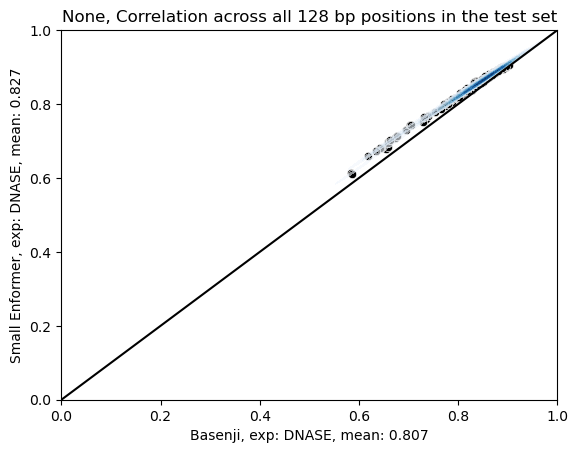

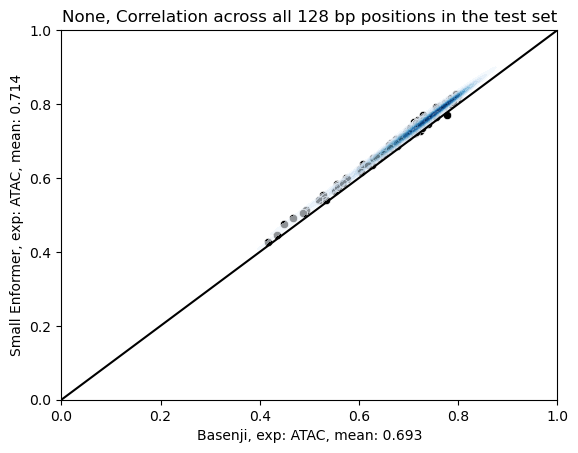

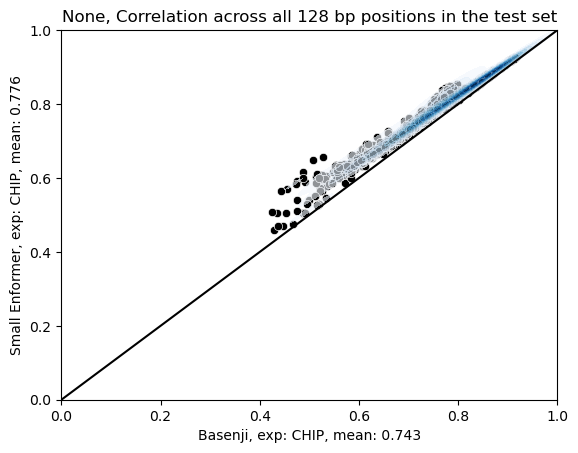

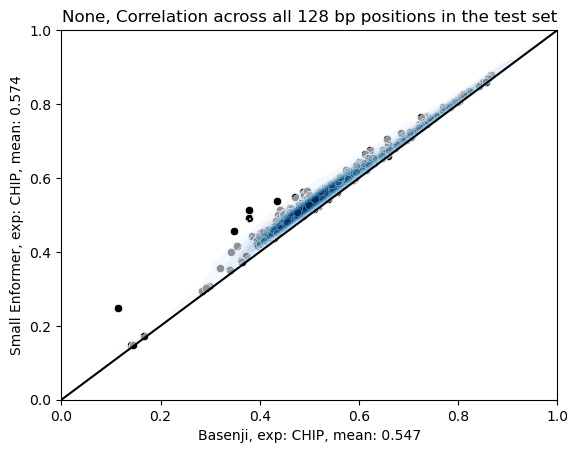

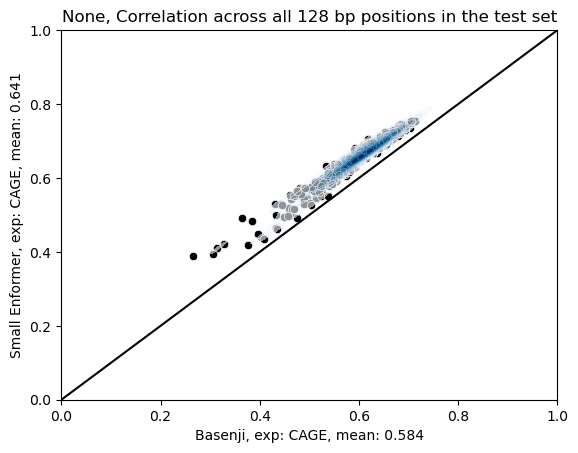

In [45]:
plot_comparison_corr_across_positions(corr_dict["basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint_mouse_test_set_corr_across_pos.pkl"],
                                    corr_dict["enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict_mouse_test_set_corr_across_pos.pkl"], 
                                    target_df=mouse_targets,
                                    ylab="Small_Enformer",
                                    title="Mouse"
                                    xlab="Basenji")